<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Adolescent_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent Group Support Vector Machine Training
Author: Stacey Rivet Beck
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls

Mounted at /content/gdrive
Cloning into 'teambrainiac'...
remote: Enumerating objects: 2380, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2380 (delta 152), reused 239 (delta 140), pack-reused 2125
Receiving objects: 100% (2380/2380), 158.74 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (1543/1543), done.
/content/teambrainiac/source/group_svm
access_data.py		    __init__.py
Adolescent_Group_SVM.ipynb  process.py
analysis.py		    Statistical_tests_decisions.ipynb
cross_validation.py	    Statistical_tests_Group.ipynb
data			    Timeseries_Cross_Validation.ipynb
Explore_data.ipynb	    train.py
Group_metrics.ipynb	    visualize.py
images			    Young_Adult_Group_SVM.ipynb


### Load path_config.py 
- we are already in the source/group_svm directory so we can just load this file without changing directories

In [2]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import *
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics, get_roi_bmaps
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

#Part I:
      Perform subject splitting into Young Adults
      Load saved pre-processed data from AWS 
                - or -
      Apply mask to .MAT data and filter data by labels
      Transform Data by:
          - Scaling data per run per subject based on normalization type
            (Z-score, Percent Signal Change or No Normalization)
          - Detrend the time series per run per subject
          - Concatenate the Training and Test Data (We can apply a Validation 
            set but not needed since we performed Cross Validation on the
            Validation set prior for model tuning)
          - Train sklearn.svm.SVC with Params: C: 10; gamma: 'auto'
            class_balanced, and max_iter = 1000
          - Collect metrics: Accuracies, probabilities, classification report
            and save into a dictionary and uploading to S3. 

#### If you wish to skip ahead, please jump to **Part II** where we can load in the metrics data to visualize the brain data. Performance metric visualization is performed in a separate notebook called **Group_analysis.ipynb** in this current directory.  

## Load Unmasked Data from AWS
- normalize and transform data
- and obtain Adolescent subjects from the first 33 subject IDs

1.) Choose which submask or which Region of interest:
  - Submasks:
      - mask :       Whole Brain, takes out any part in image that is NOT brain
      - masksubACC:  Removes the Anterior Cingulate Cortex
      - masksubAI:   Removes the Anterior Insula (Right)
      - masksubNAcc: Removes the Nucleus Accumbens
      - masksubmPFC: Removes the Medial Prefontal Cortex
  - ROIs: 
      - acc_aal: Keeps only the Anterior Cingulate Cortex, masks out rest ofbrain
      - anterior_insula_aal: Keeps only the Anterior Insula (Right), masks out rest of brain
      - mPFC: Keeps only the Medial Prefrontal Cortex, masks out rest of brain
      - nacc_aal: Keeps only Nucleus Accumbens, masks out rest of brain

2.) Choose the labels:
   - rt_labels:  These are binary, 0 for down-regulation, 1 for up-regulation.
    We care about both classes.

3.) Choose data type: here we will use AD_detrend which will tell our program
    that we want adolescent parameters and data are detrended.

4.) Choose the mask path and label paths to key into from AWS.
  - m_path_ind == 0 for submasks
  - m_path_ind == 1 for ROIs
  - l_path_ind == 0 for the binary labels


5.) Open the dictionary previously made that contains the paths to our data on
    AWS. This contains the subject IDs to get our data and split the data into
    young adult subjects. Adolescent IDs start with a 1, as in '1XXXXX-XXXXX'. 
    This data file is a dictionary pickle found in our repository under the data
    folder

6.) From the subject ID list, take the first 33 IDs, which correspond to Adolescent subjects.

7.) Check the call to AWS to see if the data we want and defined is available to
    us in AWS. If so we will load that data, if not, we will apply some
    pre-processing by masking and filtering our data timepoints by label. We
    want to keep labeled data and not the rest periods in the fMRI timeseries. 

8.) Save the data locally if it does not exist on AWS. 

In [ ]:
%%time
# Get mat file 
mask_type = 'masksubmPFC' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels'
from_mat = 'unnorm' #unnorm
data_type = "AD_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Adolescent
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 
     
if statement == False:
  print(f"Masking mat data to {mask_type}...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

## SVM Adolescent
1.) Split subject IDs either three ways to make Train, Val, Test sets or two ways for Train and Test set. If Cross-validation was performed, we will choose the latter strategy. Subjects are split by subject ID and therefore, the training data will not include any of the test data, and the test data will not include data from the training set. 

2.) Define which runs we will use for training and testing. We will train and test on runs 2 and 3.

3.) Specify whether we want to have a validation set or not. 

2.) Define which normalization strategy we wish to have. Perform Z-Score Normalization on the data per run per subject by calling transform_data() which is called inside the function run_grp_svm_model(). The function transform_data() uses other functions to process the data to get it into the correct shape needed for the classifier. 
  - Detrend_Znorm: Detrends and applies Z-score normalization using Nilearn package
  - RUNS: Normalizes per run uses Standard Scaler
  - SUBJECT: Normalizes all runs for a given subject
  - False: Does not normalize the data

3.) run_grp_svm_model() takes:
  - the data
  - which mask we have applied
  - the train/val/test IDs
  - the runs we use for training data
  - the runs used for validation data, may be False
  - the runs used for test data
  - which normalization strategy to apply
  - the data group we wish to study (AD_dtrend for adolescent in this case)
  - the mask group to specify on AWS (0 - for submask or 1 - for ROIs)

In [ ]:
# get train, test (val) data
train_ids = ad[:26]
#val_ids = ad[23:28] # Do not want this run
test_ids = ad[26:33]

group_sub_ids = (train_ids, False, test_ids)
runs_train = [1,2] # grabs the 2nd , 3rd run (index starts at 0)
runs_val = False
runs_test = [1,2] 
znorm = "Detrend_Znorm" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization


print("Number of Adolescent training examples: ", len(train_ids))
print(train_ids)
#print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(test_ids)
print(len(ad))

model_dict, metric_data = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, znorm, data_type, m_path_ind)

#Part II:
## Visualization Analysis
      Load saved metrics for a given brain mask and extract 
      bmap 
      y labels 
      alpha values 
      decision function scores

      If we are loading in the whole brain mask, we will also load in mask
      indices for regions of interest in which we want to apply as a mask
      overlay on top of the whole brain data. This will visually block out all
      areas of the brain other than the region of interest we wish to
      highlight. 
      
      - Plot the brain mask data using Nilearn's plot_img package
      - Visualize the decision function time series with y labels
      - Visualize a histogram of that represents essentially the decision
        function by plotting where voxels are in the positive or negative class
        and highlights the data where they have been mislabeled.
      - Save plots locally

**Creating the bmaps** 
        
        
      - We find the support vectors and indices from our model
        using .support_ and the weights of our model using 
        .dual_coef_. 
      - We create a dummy 3D image in the shape of our X   
        train data and store our weights in this matrix but
        only at the significant indices where our support
        vectors were found. This is what we call our alpha  
        matrix. 
      - Take the dot product of the alpha matrix (support
        vector weights) and the X train matrix. This is what we
        call our beta matrix. 
      - Then we map this matrix full of values back to the 
        original brain space of (79,95,79) using the indices of 
        our applied mask. 
      - There are many steps of reshaping the data in these 
        steps and the results were double checked on MATLAB 
        software to ensure accurate mapping. 
      - The final beta matrix is then converted to a NIFTI file 
        for use with the Nilearn image package.

In [ ]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

group = "Adolescent"
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "AD_detrend"
runs_train = [1, 2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key
metric_data = access_load_data(f'metrics/group_svm/{mask_type}/{data_type}_{runs_id}_{mask_type}_metrics.pkl', False)
print(metric_data.keys())

dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


#### Load Beta map for Visualization
- Create/load Alphas and Bmaps for Region of Interest
          We will look at:
            - Whole Brain Mask
            - medial Prefrontal Cortex
            - Nucleus Accumbens

In [11]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)


> Whole Brain Interactive Voxel Map


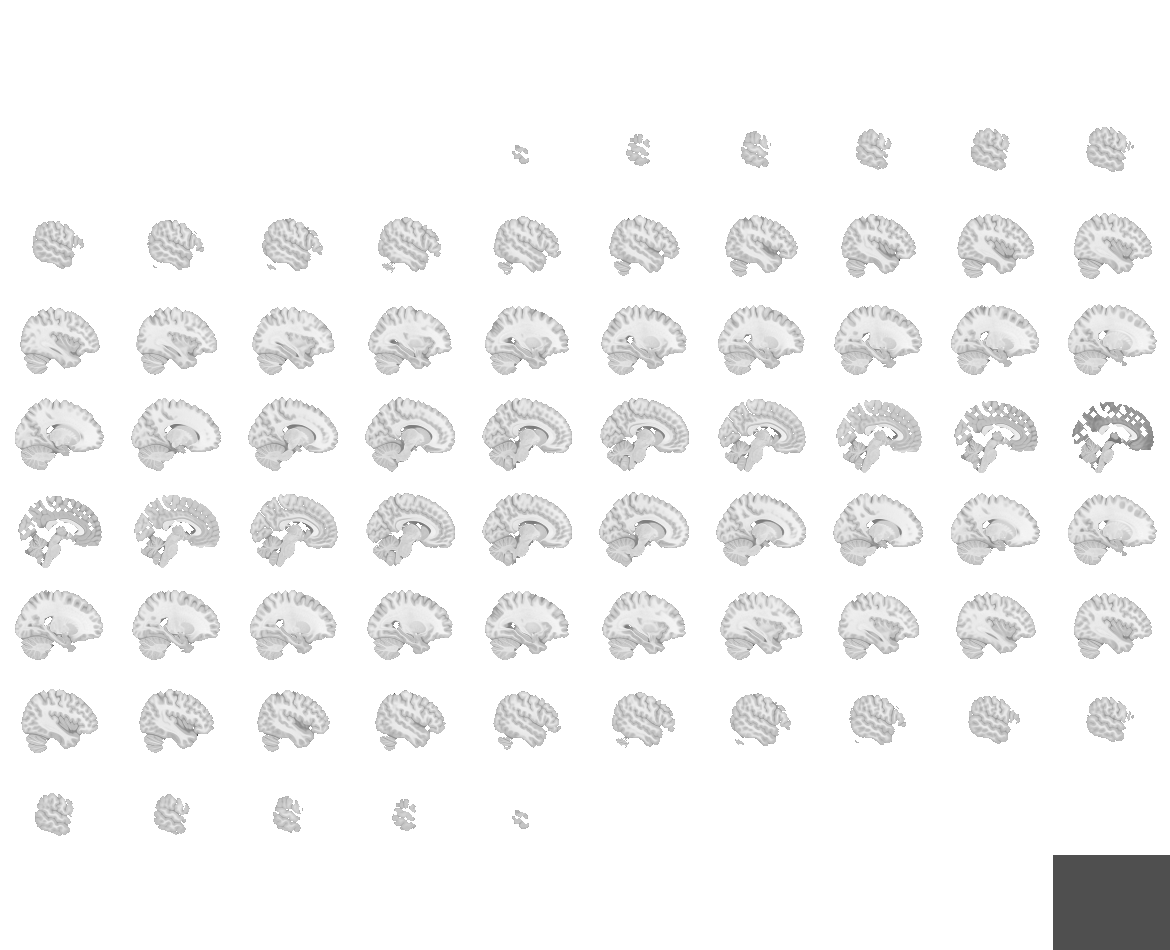
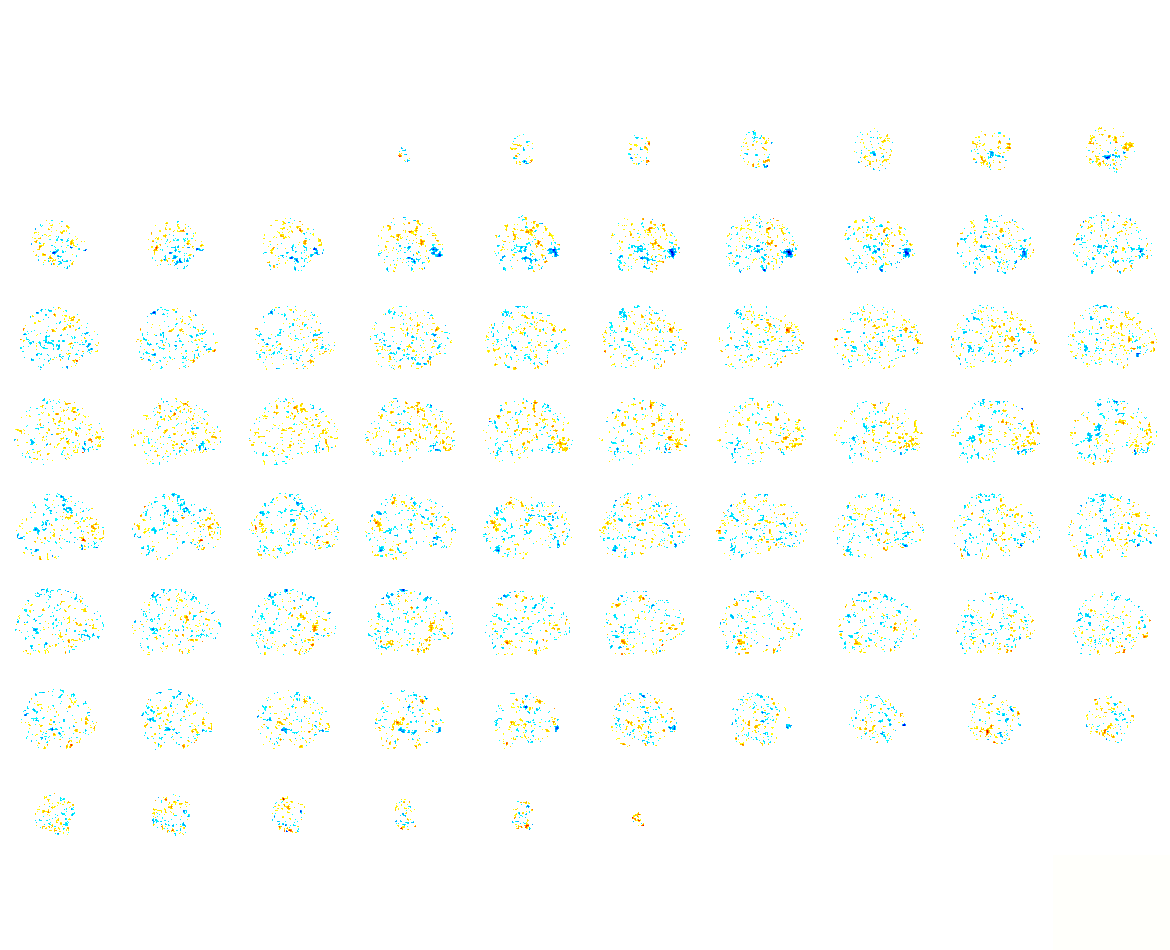

In [ ]:
# Plot interactive maps     
html_view = plotting.view_img(metric_data['bmap3'][0], 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=(4, -78, 20),#[-10, 13, -8],
                              black_bg = False,
                              draw_cross= False,
                              title=f"Adolescent Whole Brain")#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_1.html')

> Isolating the Medial Prefrontal Cortex Region of Interest using data trained on whole brain

In [ ]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'mPFC' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3pfc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3pfc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              title=f"Adolescent Medial PFC",
                              draw_cross= False,
                              resampling_interpolationst = 'continuous'
                              )
html_view.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_roi}_nocross.html')

mask shape: (79, 95, 79)


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()


> Isolate the Nucleus Accumbens in Whole Brain data

In [ ]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'nacc_aal' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3nacc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3nacc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              black_bg = False,
                              title=f"Adolescent NAcc",
                              draw_cross = False
                              )
html_view.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_roi}_nocross.html')

mask shape: (79, 95, 79)


> Let's Plot Whole Brain Slices 

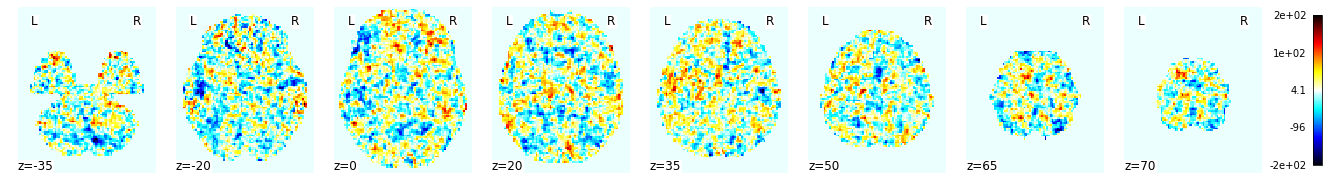

In [ ]:
# View Slices of the brain
# get bmaps for visualization
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "AD_detrend"
msk_type = 'Whole Brain'
bmap3 = metric_data['bmap3'][0]

outfile = True

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_plt_z_1.png"

  title = f"Young Adult {msk_type}"
  im = plotting.plot_img(bmap3, 
                          #bg_img = t1_image,
                          #title = title,
                          colorbar=True, 
                          black_bg = False, 
                          cut_coords = (-35,-20,0,20,35,50,65,70),
                          cmap='cold_white_hot', 
                          display_mode='z',
                          #output_file = output_file
                          )


> Plot Whole Brain with Thresholds
  - Score Percentile threshold 
  - Image Intensity threshold

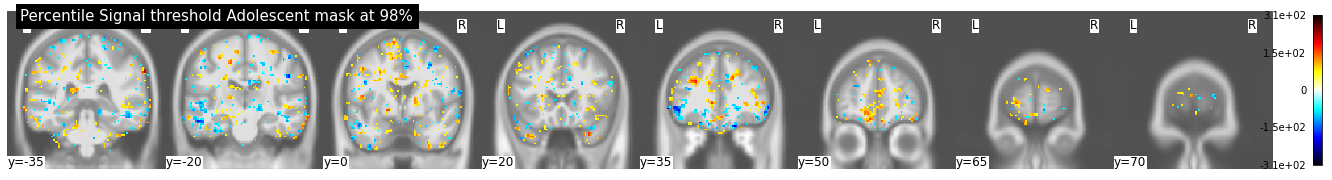

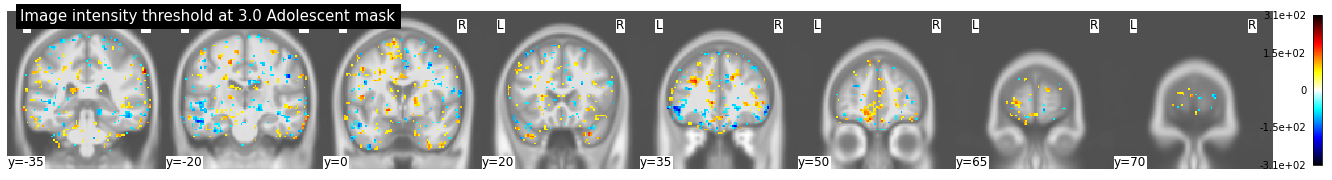

In [ ]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = True
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Adolescent {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Adolescent {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_stat_map(threshold_percentile_img,
                        title = title2 ,
                        bg_img = t1_image, 
                        display_mode='y', 
                        black_bg = False, 
                        cut_coords= (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        #annotate = False,
                        cmap = "cold_white_hot",
                        #output_file=output_file1
                       )

# Showing intensity threshold image
im3 = plotting.plot_stat_map(threshold_value_img, 
                        title = title3,
                        bg_img = t1_image, 
                        black_bg = False, 
                        display_mode='y', 
                        cut_coords= (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        #output_file=output_file2
                       )

> Plot X, Y, Z Slice to Highlight a large area of activation in the data. The Visual Cortex has been shown to be significant in the task fMRI. Further analysis might include masking out the visual cortex prior to model training. 

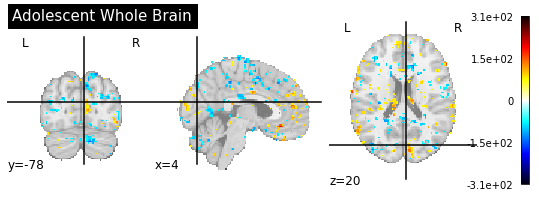

In [ ]:
# Plotting all slices in brain
title = f'Adolescent Whole Brain'
output_file3 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_xyz.png"
plotting.plot_stat_map(bmap3, #threshold_percentile_img, 
                       #bg_img = t1_image, 
                       #display_mode='z', 
                       cut_coords=(4, -78, 20), 
                       annotate = True,
                       title=title, 
                       colorbar=True,
                       black_bg = False,
                       cmap = "cold_white_hot",
                       #output_file=output_file3
                       )

> Plot Decision Function values

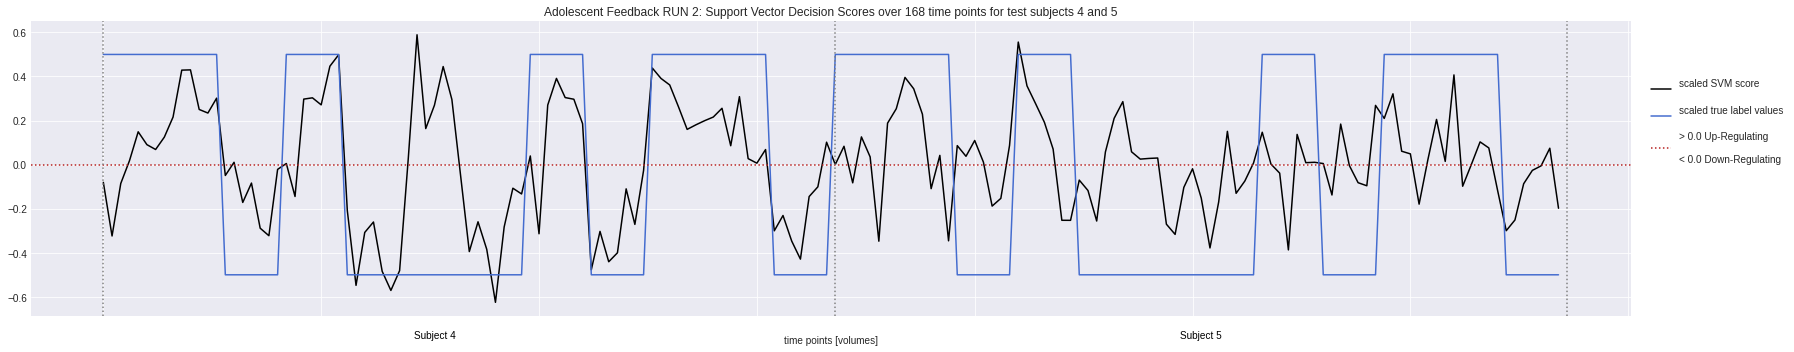

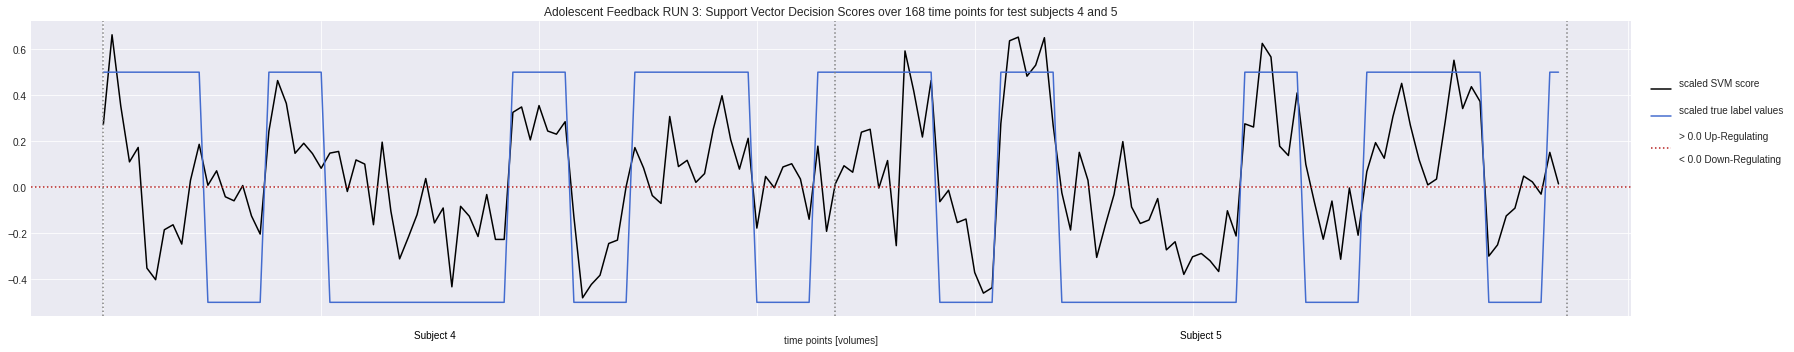

In [ ]:
# Create a DataFrame from metrics of Whole Brain
decision_scores = metric_data['test_dfunc'][0]
y = metric_data['y_t'][0]


# Save paths
filerun2 = f'/content/gdrive/MyDrive/ADOL/Adolescent_wb_run2_dfunc_line.png'
filerun3 = f'/content/gdrive/MyDrive/ADOL/Adolescent_wb_run3_dfunc_line.png'
timepoints = [
              (252, 420, -.5, .5, "Adolescent Feedback RUN 2", filerun2),
              (842, 1010, -.5, .5, "Adolescent Feedback RUN 3",filerun3)
              ] 
subjects = [4, 5]
# Plot the time series with decision scores and labels
for start, stop, min, max, run, file in timepoints:
  time = stop - start
  labels = np.where(y == 0,min,max)
  plot_decisions(decision_scores[start:stop],labels[start:stop], time, title, file, subjects)


> Plot the histogran of decision scores made by the SVM

Saving /content/gdrive/MyDrive/ADOL/AD_decision_hist.png...


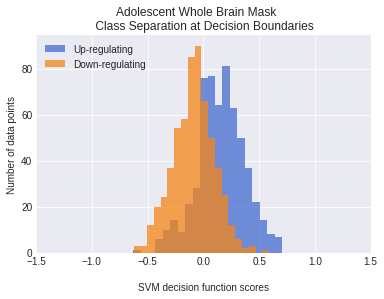

In [ ]:
y_decision_score = metric_data['test_dfunc'][0] # Decision Scores
y_t = metric_data['y_t'][0]                     # True Labels
y_ng_dscore = y_decision_score[y_t == 0]        # Decision Scores filtered by label 0
y_ps_dscore = y_decision_score[y_t == 1]        # Decision Scores filtered by label 1


savefile = '/content/gdrive/MyDrive/ADOL/AD_decision_hist.png'
if_save = True
group = "Adolescent"
suptitle = f"{group} Whole Brain Mask \n\n"

plot_hist_decision(y_ng_dscore, y_ps_dscore, suptitle, savefile, if_save)

> Fin